<a href="https://colab.research.google.com/github/FatmaBuseBorlu/Dramer-Dataset/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os
import numpy as np
import scipy.io as sio
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# --- DREAMER veri setini yükleme fonksiyonu ---
def load_dreamer_data(file_path):
    data = sio.loadmat(file_path)
    eeg_data = []
    labels = []
    for participant in range(23):
        for video in range(18):
            stimuli = data['DREAMER'][0, 0]['Data'][0, participant]['EEG'][0, 0]['stimuli'][0, 0][video, 0]
            if stimuli.size == 0:
                continue
            if stimuli.shape[0] != 14:
                stimuli = stimuli.T
            eeg_data.append(stimuli)
            valence_score = data['DREAMER'][0, 0]['Data'][0, participant]['ScoreValence'][0, 0][video, 0]
            labels.append(valence_score)
    return eeg_data, np.array(labels)

In [20]:
# --- EEG verilerini ön işleme fonksiyonu ---
def preprocess_eeg_data(eeg_data, max_length=1000):
    padded_eeg_data = []
    for sample in eeg_data:
        if sample.shape[1] < max_length:
            padding_shape = ((0, 0), (0, max_length - sample.shape[1]))
            padded_sample = np.pad(sample, padding_shape, mode='constant', constant_values=0)
        else:
            padded_sample = sample[:, :max_length]
        padded_eeg_data.append(padded_sample)
    eeg_data = np.array(padded_eeg_data)
    scaler = StandardScaler()
    eeg_data = eeg_data.reshape(eeg_data.shape[0], -1)
    eeg_data = scaler.fit_transform(eeg_data)
    eeg_data = eeg_data.reshape(-1, max_length, 14)
    return eeg_data

In [21]:
# --- RNN modeli tanımı ---
from tensorflow.keras.layers import LSTM
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    BatchNormalization(),
    Dropout(0.6),
    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.6),
    Dense(32, activation='relu'),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

In [22]:
# Veri yolu
file_path = "/content/drive/MyDrive/Colab Notebooks/DREAMER.mat"

In [23]:
# Veri setini yükleme
eeg_data, labels = load_dreamer_data(file_path)

In [24]:
# Veri ön işleme
eeg_data = preprocess_eeg_data(eeg_data)

In [25]:
# Etiketleri binary hale getirme
labels = LabelEncoder().fit_transform(labels > 5)  # Valence > 5 -> 1, aksi takdirde 0

In [26]:
# Eğitim ve test verilerini ayırma
X_train, X_test, y_train, y_test = train_test_split(eeg_data, labels, test_size=0.3, random_state=42)

In [27]:
# Sınıf ağırlıklarını hesaplama
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [28]:
# Modeli oluşturma
model = build_rnn_model(input_shape=(X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
# Callbacks: Erken durdurma
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [30]:
# Modeli eğitme
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 991ms/step - accuracy: 0.4552 - loss: 6.0078 - val_accuracy: 0.4560 - val_loss: 5.3197
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 669ms/step - accuracy: 0.4975 - loss: 5.9491 - val_accuracy: 0.4720 - val_loss: 5.2834
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 759ms/step - accuracy: 0.4929 - loss: 5.8330 - val_accuracy: 0.5040 - val_loss: 5.2666
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 931ms/step - accuracy: 0.5046 - loss: 5.8582 - val_accuracy: 0.4880 - val_loss: 5.2497
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 674ms/step - accuracy: 0.5781 - loss: 5.7343 - val_accuracy: 0.6240 - val_loss: 5.2034
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 932ms/step - accuracy: 0.5100 - loss: 5.7643 - val_accuracy: 0.7280 - val_loss: 5.1568
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 663ms/step - accuracy: 0.4513 - loss: 5.8065 - val_accuracy: 0.7360 - val_loss: 5.1400
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 666ms/step - accuracy: 0.6158 - loss: 5.6633 - val_accuracy:

In [31]:
# --- Test ---
test_logits = model.predict(X_test)
test_accuracy = tf.keras.metrics.BinaryAccuracy()(y_test, test_logits)
print(f"Test Accuracy: {test_accuracy.numpy():.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step
Test Accuracy: 0.9840


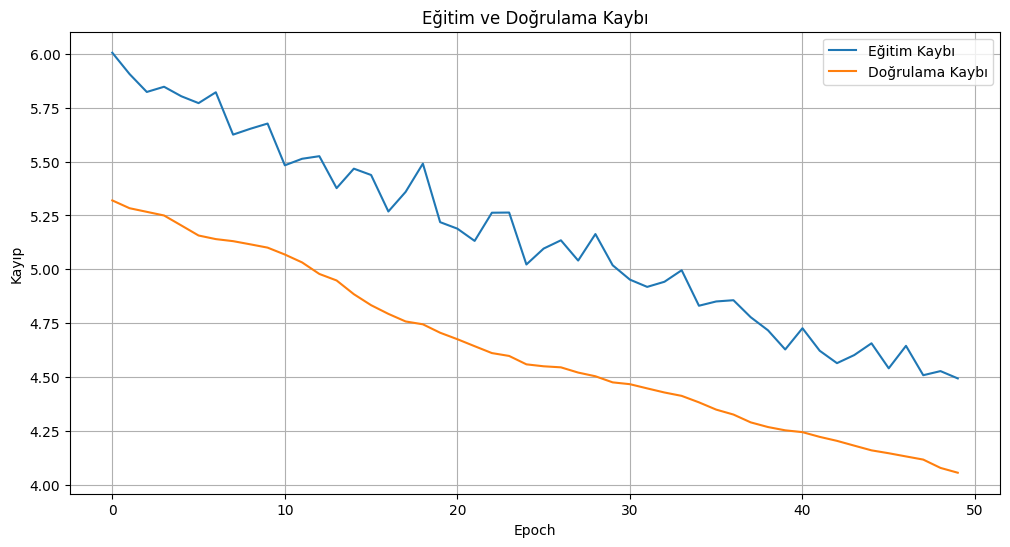

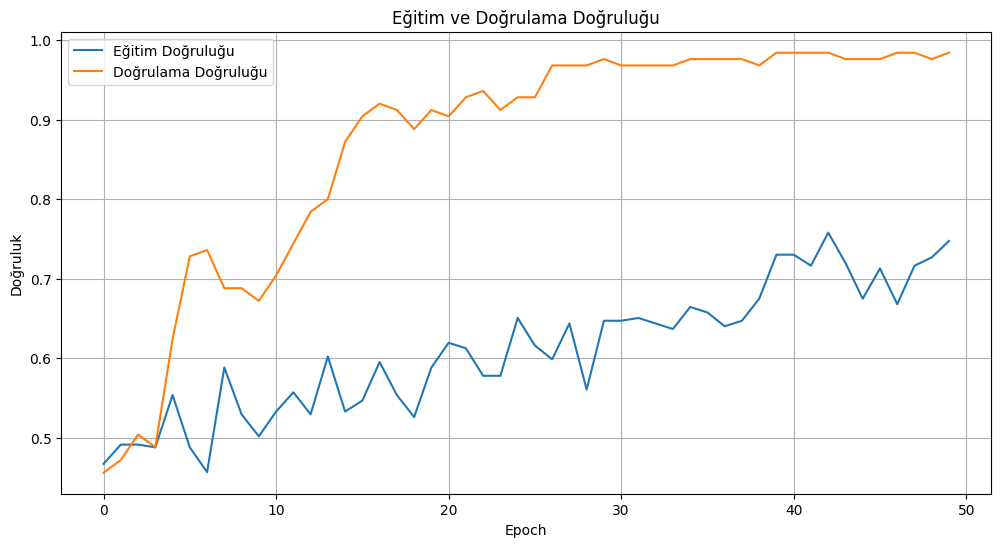

In [32]:
# Eğitim ve doğrulama kayıplarını çizme
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid()
plt.title("Eğitim ve Doğrulama Kaybı")
plt.show()

# Eğitim ve doğrulama doğruluklarını çizme
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid()
plt.title("Eğitim ve Doğrulama Doğruluğu")
plt.show()